In [180]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [181]:
from collections import defaultdict
from hydra import initialize, compose
from omegaconf import OmegaConf

from hyperopt import hp, fmin, tpe, Trials, STATUS_OK, STATUS_FAIL, space_eval
from hyperopt.early_stop import no_progress_loss
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, WeightedRandomSampler, random_split

from models import Vocabulary
from models.autoencoder import EncoderRNN, DecoderRNN, Autoencoder, VariationalAutoencoder

In [182]:
with initialize(version_base=None, config_path="conf"):
    cfg = compose(config_name="config", overrides=["+autoencoder=phone_word_frequency"])
    # cfg = compose(config_name="config", overrides=["+autoencoder=phone_word_uniform"])
cfg

{'trainer': {'batch_size': 32, 'checkpoint_path': 'autoencoder.pt'}, 'autoencoder': {'data': {'sampler': {'strategy': 'word', 'weights': 'unigram'}, 'representation': {'form': 'phone-sequence', 'drop_extras': True}}}}

## Prepare dataset

In [183]:
# "Extra" phones in TIMIT not corresponding to speech sounds
timit_extras = ["pau", "epi", "h#"]

In [184]:
df = pd.read_csv("timit_merged.csv")

In [185]:
if cfg.autoencoder.data.representation.drop_extras:
    df = df[~df.phone.isin(timit_extras)]

In [186]:
all_words = df.groupby(["dialect", "speaker", "sentence_idx", "word_idx"]).apply(lambda xs: xs.phone.str.cat(sep=" ")).value_counts()
all_words, all_word_freqs = [tuple(word.split(" ")) for word in all_words.index], list(all_words)

In [187]:
vocab = Vocabulary("")
for word in all_words:
    vocab.add_sequence(word)

In [188]:
# Prepare input tensor
max_length = 10
n = len(all_words)
input_ids = np.zeros((n, max_length), dtype=np.int32)
# target_ids = np.zeros((n, max_length), dtype=np.int32)

for idx, seq in enumerate(all_words):
    input_ids_i = [vocab.sos_token_id] + \
        [vocab.token2index[token] for token in seq][:max_length - 2] + \
        [vocab.eos_token_id]
    input_ids[idx, :len(input_ids_i)] = input_ids_i
    
all_data = TensorDataset(torch.LongTensor(input_ids), torch.LongTensor(all_word_freqs))
train_data, val_data, test_data = random_split(all_data, [0.8, 0.1, 0.1])

if cfg.autoencoder.data.sampler.strategy != "word":
    raise NotImplementedError()
if cfg.autoencoder.data.sampler.weights == "uniform":
    train_sampler = RandomSampler(train_data)
elif cfg.autoencoder.data.sampler.weights == "unigram":
    train_sampler = WeightedRandomSampler(
        train_data.dataset.tensors[1][train_data.indices], len(train_data.indices))

train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=cfg.trainer.batch_size)
val_dataloader = DataLoader(val_data, batch_size=cfg.trainer.batch_size)

## Train

In [189]:
def train_batch(data, autoencoder, opt):
    opt.zero_grad()

    batch_input, _ = data
    batch_target, _ = data

    losses, _ = autoencoder.forward_loss(batch_input, batch_target)
    loss = losses["loss"]
    loss.backward()
    
    opt.step()

    return losses

def train_epoch(dataloader, autoencoder, opt):
    total_losses = defaultdict(float)
    for data in dataloader:
        losses = train_batch(data, autoencoder, opt)
        for k, loss in losses.items():
            total_losses[k] += loss.item()
    
    return {k: v / len(dataloader) for k, v in total_losses.items()}

In [220]:
def evaluate(dataloader, autoencoder):
    with torch.no_grad():
        total_loss = 0
        decoded_sequences = []
        for data in dataloader:
            batch_input, _ = data
            batch_target, _ = data
            
            losses, dec_outputs = autoencoder.forward_loss(batch_input, batch_target)
            loss = losses["recon_loss"]
            total_loss += loss.item()

            _, topi = dec_outputs.topk(1, dim=-1)
            for seq in topi:
                decoded_tokens = []
                for idx in seq:
                    if idx == autoencoder.vocabulary.eos_token_id:
                        decoded_tokens.append("<EOS>")
                        break
                    decoded_tokens.append(autoencoder.vocabulary.index2token[idx.item()])

                decoded_sequences.append(decoded_tokens)
    
    total_loss /= len(val_dataloader)
    return total_loss, decoded_sequences

In [221]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [222]:
def train(train_dataloader, val_dataloader, autoencoder,
          num_batches=500, early_stopping=None,
          learning_rate=1e-2, weight_decay=0,
          print_every=10, val_every=10):
    print_loss_total = defaultdict(float)
    
    opt = optim.Adam(autoencoder.parameters(), lr=learning_rate,
                     weight_decay=weight_decay)
    
    val_loss = None
    batch_iter = iter(train_dataloader)
    for batch in range(1, num_batches + 1):
        try:
            data = next(batch_iter)
        except StopIteration:
            batch_iter = iter(train_dataloader)
            data = next(batch_iter)

        losses = train_batch(data, autoencoder, opt)
        for k, loss in losses.items():
            print_loss_total[k] += loss
        
        if batch % print_every == 0:
            print_loss_avg = {k: v / print_every for k, v in print_loss_total.items()}
            print_loss_total = defaultdict(float)
            loss_desc = ", ".join("%s: %.4f" % (k, v) for k, v in print_loss_avg.items())
            print(f"{batch}\t{loss_desc}")
            
        if batch % val_every == 0:
            val_loss, _ = evaluate(val_dataloader, autoencoder)
            if batch % print_every == 0:
                print("--- val loss: %.4f" % val_loss)

            if early_stopping is not None and early_stopping.early_stop(val_loss):
                print("Early stopping at batch %d" % batch)
                break

    return val_loss

In [223]:
def fit_for_args(args):
    model = VariationalAutoencoder(args["hidden_size"], vocab, kl_weight=args["kl_weight"])
    early_stopping = EarlyStopper(patience=5, min_delta=0.001)

    val_loss = train(train_dataloader, val_dataloader, model, early_stopping=early_stopping,
                     learning_rate=args["learning_rate"], print_every=10000, val_every=2)
    return model, val_loss

def hyper_objective(args):
    model, final_losses = fit_for_args(args)
    return {"status": STATUS_OK, "loss": final_losses["recon_loss"]} \
        if final_losses is not None else {"status": STATUS_FAIL}

In [224]:
hparam_space = {
    "hidden_size": hp.choice("hidden_size", [16, 32, 64]),
    "learning_rate": hp.loguniform("learning_rate", np.log(1e-4), np.log(1e-1)),
    "kl_weight": hp.loguniform("kl_weight", np.log(1e-5), np.log(1e-1)),
}

In [225]:
trials = Trials()
best = fmin(hyper_objective, space=hparam_space, algo=tpe.suggest,
            max_evals=200, early_stop_fn=no_progress_loss(iteration_stop_count=5), trials=trials)
best

Early stopping at batch 114                            
Early stopping at batch 110                                                     
Early stopping at batch 158                                                     
  2%|▎         | 5/200 [00:47<31:05,  9.57s/trial, best loss: 377.4029235839844]


{'hidden_size': 1,
 'kl_weight': 0.0470278691206668,
 'learning_rate': 0.03303376519646531}

In [226]:
best_model, losses = fit_for_args(space_eval(hparam_space, best))
print({k: loss.item() for k, loss in losses.items()})

Early stopping at batch 96
{'loss': 407.636474609375, 'recon_loss': 401.2494812011719, 'kl_loss': 135.8129425048828}


## Decode

In [227]:
val_loss, val_outputs = evaluate(val_dataloader, best_model)

In [228]:
val_loss

640.9502029418945

In [209]:
val_inputs = [" ".join(best_model.vocabulary.index2token[idx.item()] for idx in seq.squeeze())
              for batch, _ in val_dataloader
              for seq in batch]

In [210]:
list(zip(val_inputs[:20], [" ".join(toks) for toks in val_outputs[:20]]))

[('<SOS> q ow pcl p ix n dx <EOS> <SOS>', '<SOS> dh ix n p r n <EOS>'),
 ('<SOS> k ow kcl k ax n ah tcl <EOS>', '<SOS> dh eh n k <EOS>'),
 ('<SOS> s ax pcl p er bcl b l <EOS>', '<SOS> dh ux <EOS>'),
 ('<SOS> axr n tcl t eh l ax dcl <EOS>', '<SOS> dh <EOS>'),
 ('<SOS> q eh gcl g eh n s tcl <EOS>', '<SOS> dh ix r g <EOS>'),
 ('<SOS> r ae pcl p <EOS> <SOS> <SOS> <SOS> <SOS>',
  '<SOS> dh ae gcl p r <SOS> <SOS> <SOS> <SOS>'),
 ('<SOS> m eh zh er dcl <EOS> <SOS> <SOS> <SOS>', '<SOS> dh ay dcl <EOS>'),
 ('<SOS> dcl d ix pcl p aa r q <EOS>', '<SOS> dh d <EOS>'),
 ('<SOS> q eh v r iy <EOS> <SOS> <SOS> <SOS>', '<SOS> dh ix r <EOS>'),
 ('<SOS> sh ih m axr dcl d <EOS> <SOS> <SOS>', '<SOS> dh iy <EOS>'),
 ('<SOS> f aa l ax dcl <EOS> <SOS> <SOS> <SOS>', '<SOS> dh iy r <EOS>'),
 ('<SOS> hv ih s tcl t eh r ix <EOS>', '<SOS> dh ae <EOS>'),
 ('<SOS> pcl p ay n <EOS> <SOS> <SOS> <SOS> <SOS>', '<SOS> dh p r <EOS>'),
 ('<SOS> g er l iy <EOS> <SOS> <SOS> <SOS> <SOS>', '<SOS> dh ix <EOS>'),
 ('<SOS> s ix kc

## Checkpoint

In [ ]:
torch.save(best_model, cfg.trainer.checkpoint_path)

## Plot

In [ ]:
with torch.no_grad():
    val_encodings = []
    for data in val_dataloader:
        batch_inputs, _ = data
        _, batch_encodings, _ = best_model.encode(batch_inputs)
        val_encodings.append(batch_encodings.squeeze(0))

    val_encodings = torch.cat(val_encodings)
val_encodings.shape

torch.Size([1140, 128])

In [ ]:
pca = PCA(2).fit(val_encodings)
val_encodings_pca = pca.transform(val_encodings)

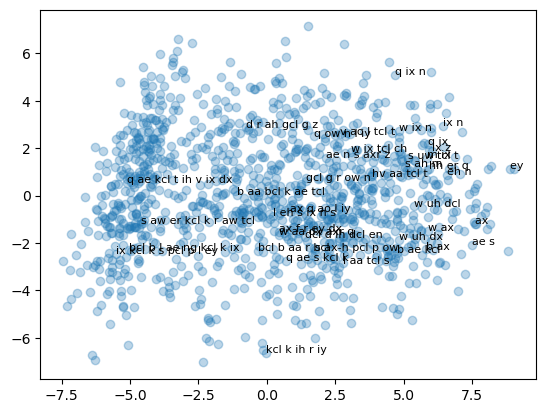

In [ ]:
plt.scatter(val_encodings_pca[:, 0], val_encodings_pca[:, 1], alpha=0.3)

sample_ps = val_data.dataset.tensors[1][val_data.indices].float().numpy()
sample_ps /= sample_ps.sum()
for idx in np.random.choice(len(val_encodings_pca), size=40, replace=False,
                            p=sample_ps):
    input_i = val_inputs[idx]
    input_i = input_i[len("<SOS> "):]
    input_i = input_i[:input_i.index("<EOS>")]
    
    plt.text(val_encodings_pca[idx, 0], val_encodings_pca[idx, 1],
             input_i, fontdict={"fontsize": 8})

## Visualize distances

In [ ]:
from scipy.spatial.distance import pdist, squareform

In [ ]:
val_inputs_condensed = [input_str[len("<SOS> "):input_str.index("<EOS>")]
                        for input_str in val_inputs]

In [ ]:
item_distances = squareform(pdist(val_encodings))
item_distances = pd.DataFrame(item_distances)
# Keep just the upper triangle, not including diagonal
item_distances = item_distances.where(np.triu(np.ones(item_distances.shape), k=1).astype(bool))
item_distances.index = val_inputs_condensed
item_distances.columns = val_inputs_condensed
item_distances = item_distances.stack().dropna()

In [ ]:
item_distances.sort_values().head(10)

kcl k r ih s kcl k r      kcl k r ih s kcl k r        0.911773
th axr m aa m ax dx er    th axr m aa m ax dx er      1.073387
dcl d ix v eh l ax pcl    dcl d ix v eh l ax pcl      1.328892
hv ah ng gcl g eh r iy    hv ah ng gcl g eh r iy      1.495200
kcl k en tcl t ey n dcl   kcl k en tcl t ey n dcl     1.690457
ax n ae l s ix s          n ae l ax s ix s            2.073590
ix n tcl t ae gcl g en    ix n tcl t ae gcl g ix      2.084162
f r eh n dcl z            f r eh n dcl d z            2.087759
kcl k eh r f uh           kcl k eh r f el             2.403477
l ow dcl d z              l ow dcl z                  2.522015
dtype: float64

In [ ]:
item_distances.sort_values().tail(10)

uh s                       q ae dx ih kcl k w ax     19.676583
m iy l iy n ow z dcl       y axr tcl                 19.682605
iy kcl k w ih pcl m ih     ey                        19.714738
ey                         q ae dx ih kcl k w ax     19.804743
bcl b aa ng gcl g ow z     hv iy                     19.811393
jh uh                      q ae dx ih kcl k w ax     19.876939
kcl k ow ax gcl g z ih     hv iy                     19.927867
d uh                       q ae dx ih kcl k w ax     19.936440
kcl k ow ax gcl g z ih     y axr tcl                 20.104920
bcl b ih bcl l iy aa gcl   ey                        20.166254
dtype: float64